### Setup (see ageron/mandson-ml)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, re

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Get the data

In [2]:
import pandas as pd

SCOTCH_PATH = os.path.join("data")

def load_scotch_data(scotch_path="./data"):
    csv_path = os.path.join(scotch_path, "scotch_review.csv")
    return pd.read_csv(csv_path)

In [3]:
scotch=load_scotch_data()
scotch.head()

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


In [4]:
def get_alc(string):
    try:
        return float(re.findall(r'(?<!\%)(\d*\.\d|\d{1,2})',string)[-1])
    except:
        return np.nan    

In [5]:
def get_age(string):
    try:
        return float(re.findall(r'\d{1,2}(?=\syear)',string)[-1])
    except:
        return np.nan

In [6]:
def get_date(string,year_today=2020):
    try:
        return year_today-int(re.findall(r'(?<=\s)19\d{2}',string)[-1])
    except:
        return np.nan

In [7]:
def final_age(first,second):
    if first>0:
        return first
    else:
        return second

In [8]:
scotch['Alc_%']=scotch['name'].progress_apply(get_alc)
scotch['Age_y_1']=scotch['name'].progress_apply(get_age)
scotch['Age_y_2']=scotch['name'].progress_apply(get_date)
scotch['Age_y']=scotch.progress_apply(lambda x: final_age(x['Age_y_1'],x['Age_y_2']),axis=1)
scotch.drop('Unnamed: 0',axis=1,inplace=True)
scotch.drop('Age_y_1',axis=1,inplace=True)
scotch.drop('Age_y_2',axis=1,inplace=True)
scotch.head(5)

,name,category,review.point,price,currency,description,Alc_%,Age_y
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ...",40.0,NaN
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...,40.5,42.0
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...,42.9,46.0
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...,53.4,NaN
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin...",40.0,NaN


In [9]:
scotch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 8 columns):
name            2247 non-null object
category        2247 non-null object
review.point    2247 non-null int64
price           2247 non-null object
currency        2247 non-null object
description     2247 non-null object
Alc_%           2242 non-null float64
Age_y           1565 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 140.6+ KB


In [10]:
scotch['category'].value_counts()

Single Malt Scotch            1819
Blended Scotch Whisky          211
Blended Malt Scotch Whisky     132
Single Grain Whisky             57
Grain Scotch Whisky             28
Name: category, dtype: int64

In [11]:
scotch.describe()

,review.point,Alc_%,Age_y
count,2247.000000,2242.000000,1565.000000
mean,86.700045,47.769224,23.995527
std,4.054055,6.513113,11.764390
min,63.000000,0.000000,3.000000
25%,84.000000,43.000000,15.000000
50%,87.000000,46.000000,22.000000
75%,90.000000,52.100000,30.000000
max,97.000000,98.000000,70.000000


In [12]:
scotch[['name','category','review.point','price']].sort_values('review.point',ascending=False)[:10]

,name,category,review.point,price
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00
8,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.00
11,"Macallan 1976 Vintage, 29 year old, cask #1135...",Single Malt Scotch,96,1500.00
10,"The Glenlivet Cellar Collection, 1969 vintage,...",Single Malt Scotch,96,750.00
9,"Glenfarclas Family Casks 1954 Cask #1260, 47.2%",Single Malt Scotch,96,3360
12,The Last Drop (distilled at Lochside) 1972 (ca...,Grain Scotch Whisky,96,3108
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.00
6,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.00


### Visualizations

In [13]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


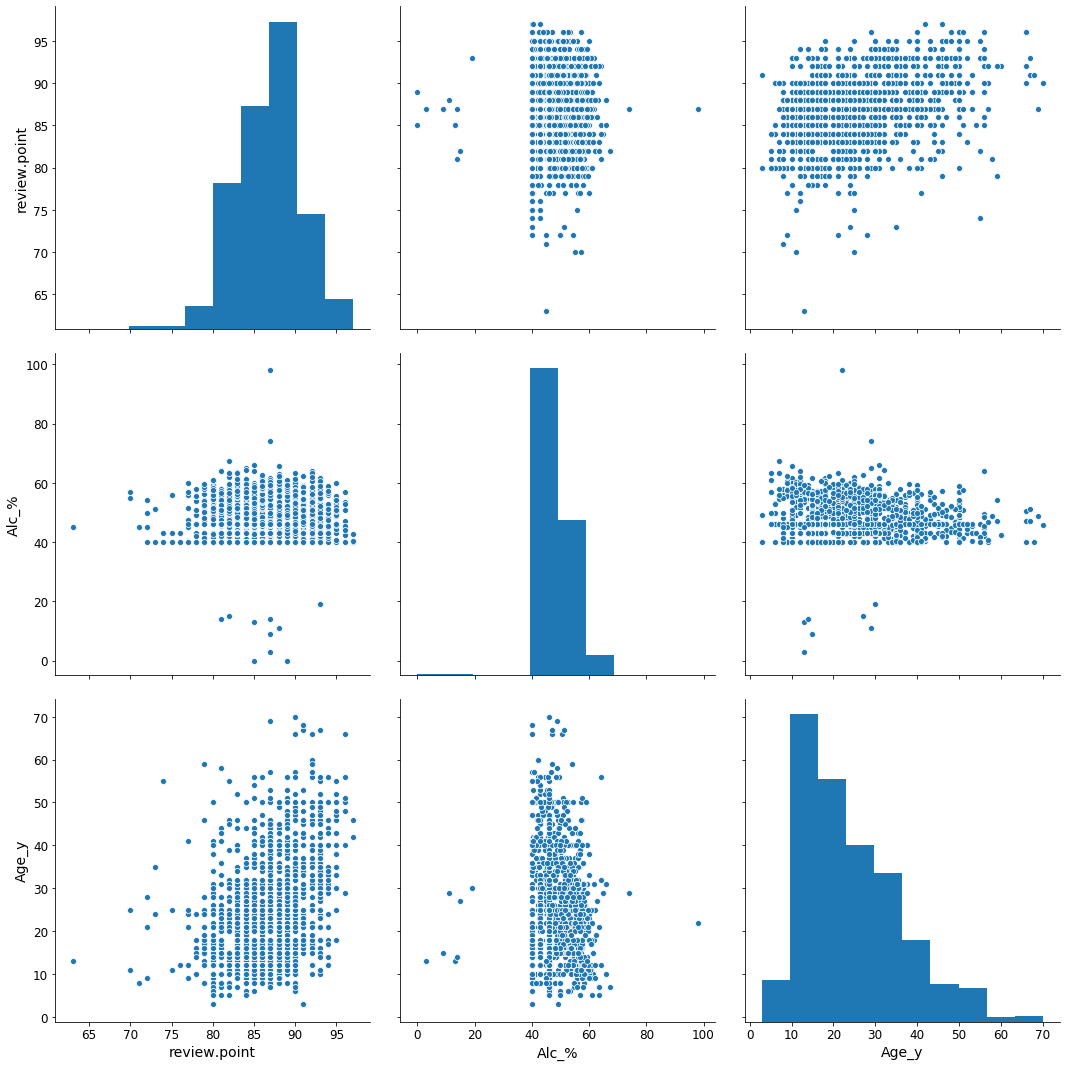

In [14]:
sns.pairplot(scotch, size=5)

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


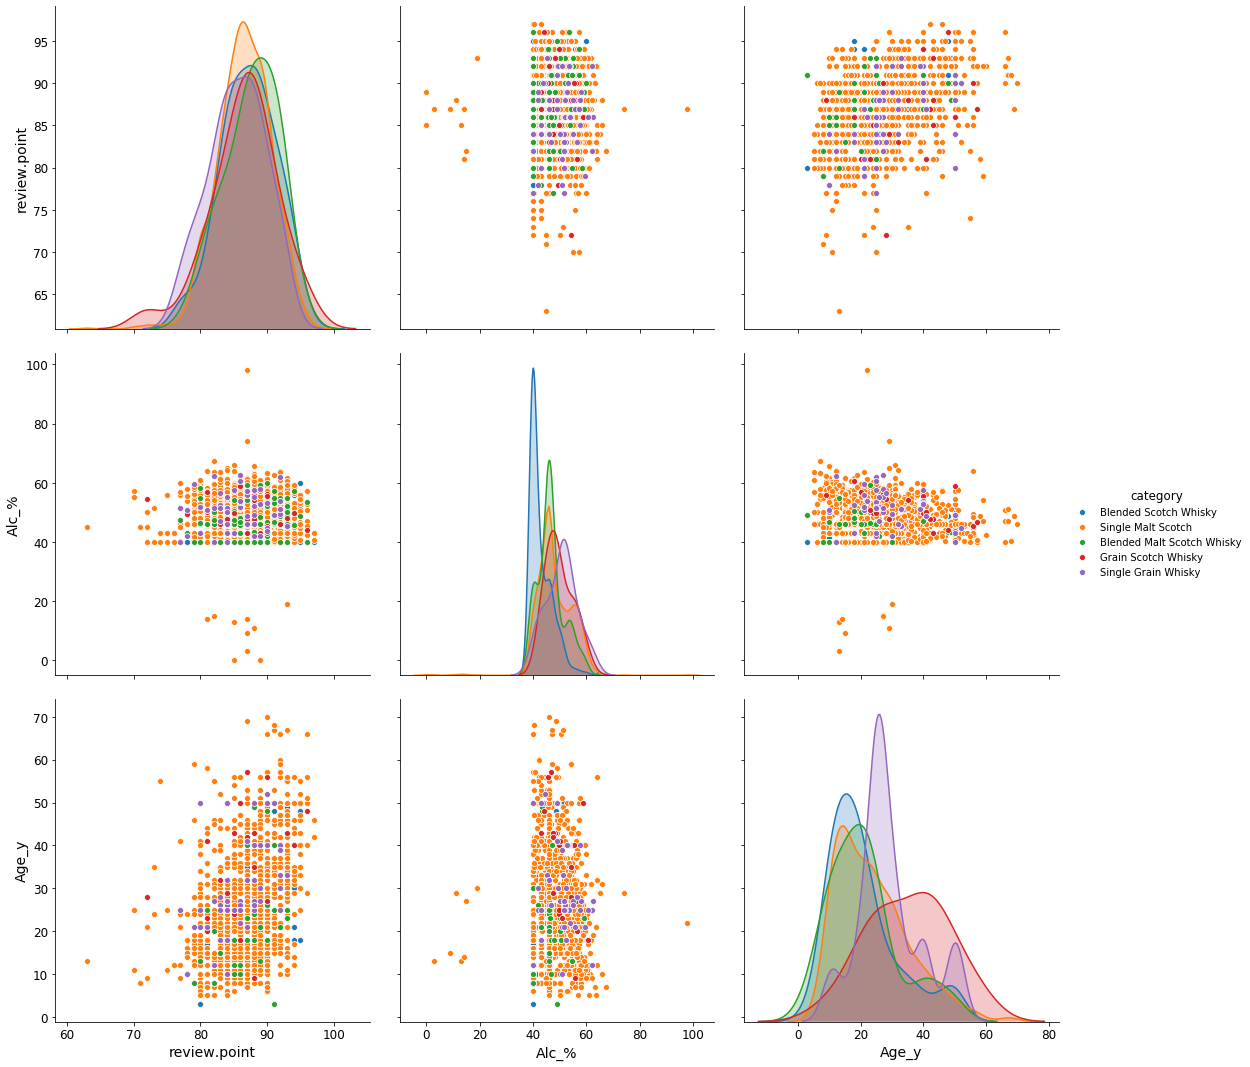

In [15]:
sns.pairplot(scotch, hue='category', size=5)

In [16]:
save_fig("scotch_category")

Saving figure scotch_category


<Figure size 432x288 with 0 Axes>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f667c945790>,
      dtype=object)

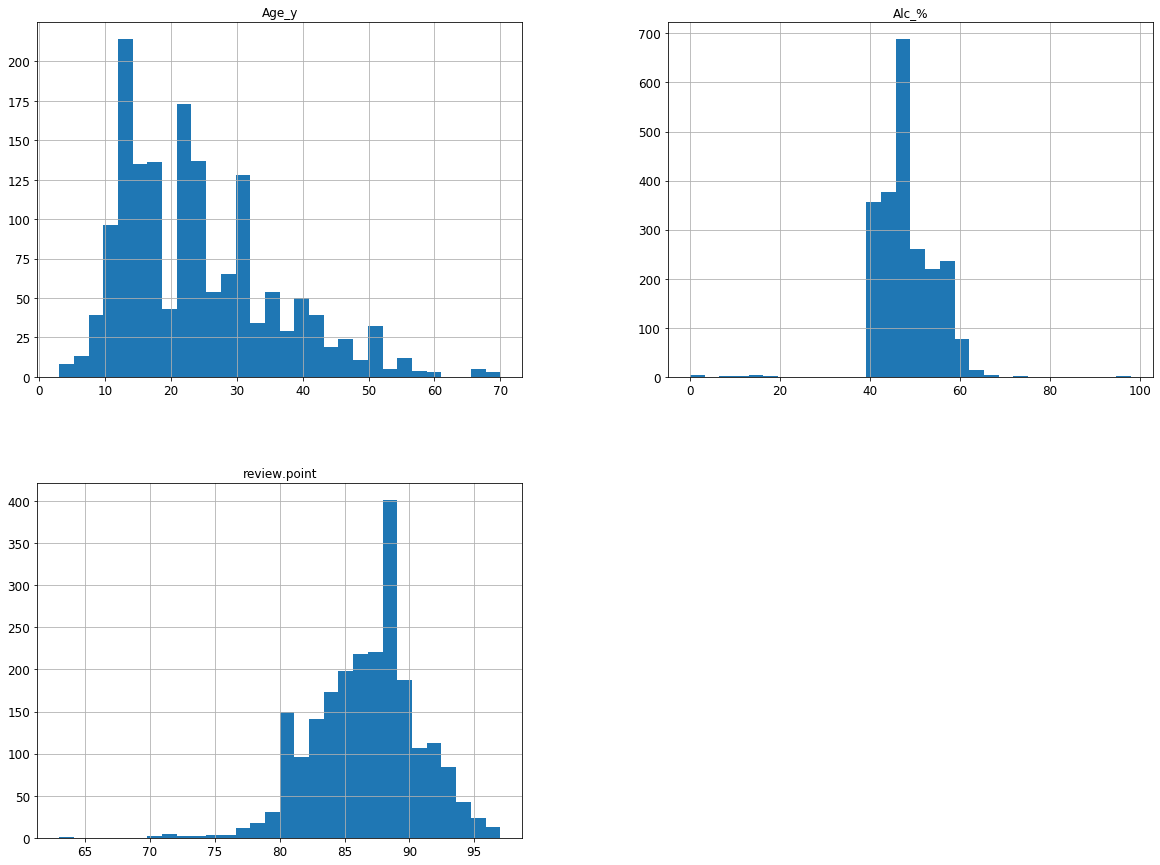

In [17]:
scotch.hist(bins=30, figsize=(20,15))

In [18]:
save_fig("scotch_attribute_hist")

Saving figure scotch_attribute_hist


<Figure size 432x288 with 0 Axes>

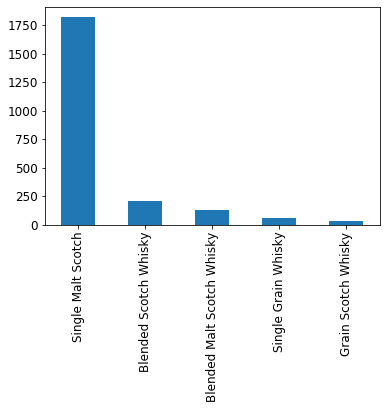

In [19]:
scotch[('category')].value_counts().plot(kind='bar')

In [20]:
save_fig("scotch_cat_valuecounts")

Saving figure scotch_cat_valuecounts


<Figure size 432x288 with 0 Axes>

In [21]:
aaa="Johnnie Walker Blue Label, 40%"

In [22]:
scotch.keys()[0]

'name'